<a href="https://colab.research.google.com/github/sefrancogo/Analitica-de-Datos/blob/master/Covid_Paises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediccion de Contagios por Covid-19



### Cargar Base de Datos


In [86]:
!pip install wget 
import pandas as pd
import numpy as np 
import wget 
import matplotlib.pyplot as plt
%matplotlib inline

url = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv"
#path = 'data/Casos_positivos_de_COVID-19_en_Colombia04_15_2020.csv'

wget.download(url, 'datos_covid_paises.cvs')
data = pd.read_csv('datos_covid_paises.cvs')
data

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750,766
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743,743
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
260,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,6,6,34,34
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,8,8


### Dividir el conjunto de Datos


In [0]:
#funcion ventaneo
def covid_win(serie,w=5):
    pi =0
    pf = w
    X = serie[pi:pf].reshape(1,-1)
    y = serie[pf+1].reshape(1,-1)
    pi += 1
    pf+= 1
    while pf+1 < serie.shape[0]:        
        X = np.append(X,serie[pi:pf].reshape(1,-1),axis=0)
        y = np.append(y,serie[pf+1].reshape(1,-1),axis=0)
        pi += 1
        pf+=1
    return X, y # X \in Real^{N x P = w}, y \in Real^N

In [0]:
#Ubicar Posicion de pais
ii = data[data.columns[1]] == 'Colombia'

#contagios  acumulados
serie = np.array(data.iloc[np.where(ii)[0][0],4:])
#numero contagiados por dia
serie_d = np.append(0,np.diff(serie))
#serie_d = np.append(0,np.cumsum(np.diff(serie)))

X, y = covid_win(serie,w=5)
X_d, y_d = covid_win(serie_d,w=5)

In [89]:
X[-1,:]

array([4561, 4881, 5142, 5379, 5597], dtype=object)

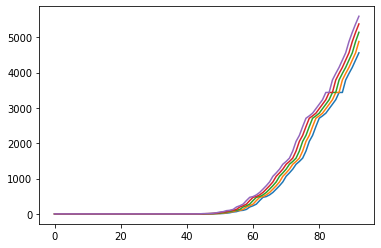

In [90]:
plt.plot(X)

### Análisis Exploratorio PCA

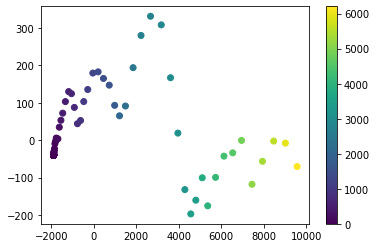

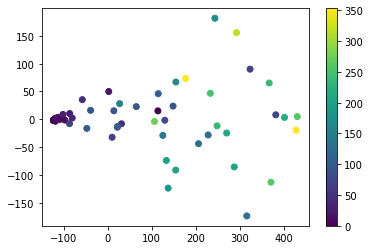

In [91]:
from sklearn.decomposition import PCA

red = PCA()
red_d = PCA()

z = red.fit_transform(X)
z_d = red_d.fit_transform(X_d)

plt.scatter(z[:,0],z[:,1],c=y)
plt.colorbar()
plt.show()

plt.scatter(z_d[:,0],z_d[:,1],c=y_d)
plt.colorbar()
plt.show()

### Análisis Exploratorio TSNE

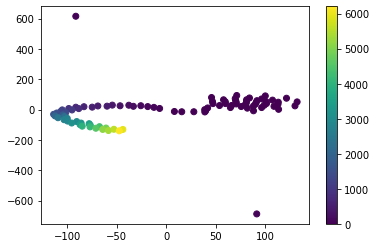

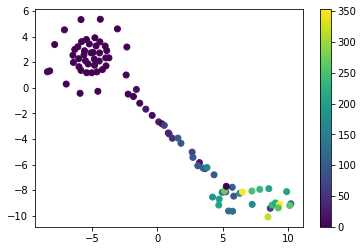

In [92]:
from sklearn.manifold import TSNE

red = TSNE(n_components = 2, perplexity=10)
red_d = TSNE(n_components = 2, perplexity=10)

z = red.fit_transform(X)
z_d = red.fit_transform(X_d)

plt.scatter(z[:,0],z[:,1],c=y)
plt.colorbar()
plt.show()

plt.scatter(z_d[:,0],z_d[:,1],c=y_d)
plt.colorbar()
plt.show()

### Extrer conjunto de Entrenamiento y Prueba
Cuando se tienen pocos datos es necesario realizar una validaación cruzada anidada.

### Función Validación Cruzada Anidada


In [0]:
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from joblib import dump, load

def V_Cruzada_Anidada(X_data,Y_data,steps,parameters):
  
  Niter = 10                           #numero particiones outter loop nested cross-validation
  msev = np.zeros((Niter,len(steps)))  #arreglo para guardar acierto
  best_estimators = []                 #mejor metodo por iteracion
  ###clave del funcionamiento
  best_hyperpar = []                   #mejor metodo por iteracion 
            

  for j in range(Niter): #outter loop
      print('it %d/%d'%(j+1,Niter))
      #particiono datos outter loop
      X_train, X_test, y_train, y_test = train_test_split(X_data,Y_data,test_size=0.3) # xtrain 60, xtest 26

      for r in range(len(steps)): #recorro todos los posibles modelos a probar en iteracion j del outter loop
          grid_search = GridSearchCV(Pipeline(steps[r]), parameters[r],cv=5,verbose=10,scoring='neg_mean_absolute_error',n_jobs=5) #cv inner loop
          #xtrain gridsearchcv xtrain split en 12 / cv, 60/5 = 12, xtrain 48 datos validar 12
          # cv = N -> leave one out N <30
          
          #generar mejor modelo
          grid_search.fit(X_train,y_train)
          
          #estimar salida conjunto de test
          y_pred = grid_search.best_estimator_.predict(X_test)
          
          #guardar mejor modelo
          best_estimators.append(grid_search.best_estimator_)
          best_hyperpar.append(grid_search.best_params_)

          #guardar acierto
          msev[j,r] = mse(y_test,y_pred)
          #print('it %d/%d-Modelo %d/%d'%(j+1,Niter,r,len(steps)))
          #print(best_hyperpar)
          #print('mse:',msev[j,r])

          savedata = {
            'acc':msev,
            'best_models':best_estimators,
            'best_parameters':best_hyperpar,
              } 
          #dump(savedata,'covid19_1.joblib')

  return best_estimators,best_hyperpar,msev

#### Validación Cruzada Anidada LR:

- Normalización StandadScalar
- Representación PCA
- Regresor LinearRegression



In [94]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg',  LinearRegression())],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  LinearRegression())]
          ]

parameters = [
                {
                 },
                {
                 'rep__n_components':[0.5,0.75,0.9]
                 }
               ]

label_model_LR = ['NorSC-LR','NorSC-PCA-LR']

B_Model_LR, B_Hiperpara_LR, MAE_LR = V_Cruzada_Anidada(X,y,steps,parameters)

it 1/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    2.3s remaining:    1.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0328s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0328s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  12 out of  15 | elapsed:    0.1s remaining:    

Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 2/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 3/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  12 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0051s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0067s.) Setting batch_size=2.
[Para

Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 4/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 5/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  12 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0054s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0140s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Para

it 6/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 7/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 8/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0075s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0116s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0116s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.0s remaining:  

Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 9/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 10/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0147s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0147s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  12 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0046s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Pa

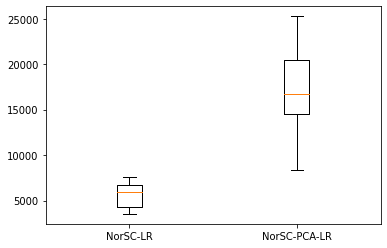

In [95]:
plt.boxplot(MAE_LR)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model_LR)
plt.show()

In [96]:
MAE_LR

array([[ 4316.62522014, 13025.40761798],
       [ 6302.14393689, 16403.23117693],
       [ 4111.62065837, 17978.31389577],
       [ 7573.91225218, 22170.50413964],
       [ 3535.63222529,  8363.2704663 ],
       [ 6892.97086029, 21282.63872216],
       [ 5889.58202789, 16428.02434862],
       [ 6862.02306962, 25267.73963633],
       [ 4240.7917373 , 13890.49060141],
       [ 5909.07741271, 16993.54552206]])

In [97]:
B_Hiperpara_LR

[{},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5}]

In [98]:
steps =  [('scaler', StandardScaler()),
          #('rep', PCA(n_components=0.5)),                         
          ('reg', LinearRegression())]

Mod_SC_LR = Pipeline(steps = steps)
Mod_SC_LR.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [99]:
from datetime import date
Xn = X[-1]
#Xn = [4881, 5142, 5379, 5948, 6207]
#Xn=np.matrix([Xn])

Xn = Xn.reshape(1,-1)
Pre_SC_LR = Mod_SC_LR.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo LinearRegression:',Pre_SC_LR)

Número de contagiados en los últimos 5 días: [[4561 4881 5142 5379 5597]]
Predicción contagios para 2020-04-30 usando un modelo LinearRegression: [[6176.07241785]]


#### Validación Cruzada Anidada Ridge:

- Normalización StandadScalar
- Representación PCA
- Regresor LinearRidge


In [100]:
steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg',  Ridge( ))],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  Ridge())]
          ]

parameters = [
                {'reg__alpha':[1e-3,1e-2,1e-1,1],
                 'reg__solver':['svd', 'cholesky', 'lsqr', 'sag', 'saga']
                 },
                {'rep__n_components':[0.5,0.9],
                 'reg__alpha':[1e-3,1e-2,1e-1,1],
                 'reg__solver':['svd', 'cholesky', 'lsqr', 'sag', 'saga']
                 }
               ]

label_model_R = ['NorSC-R','NorSC-PCA-R']

B_Model_R, B_Hiperpara_R, MAE_R = V_Cruzada_Anidada(X,y,steps,parameters)

it 1/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0140s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0362s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0828s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  77 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fa

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0932s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0806s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 125 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 141 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 163 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 176 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 189 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0078s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

it 2/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0757s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0093s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0433s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0776s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1175s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0112s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

it 3/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0921s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0103s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0381s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1101s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0615s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0079s.) Setting batch_size=2.


it 4/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0630s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0537s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0093s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0377s.) 

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0893s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1318s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 143 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0095s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0328s.) Setting batch_size=4.


it 5/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0723s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0102s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0598s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1079s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0548s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0125s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0345s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks  

it 6/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0150s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0718s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0590s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1769s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0077s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

it 7/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0683s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0196s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0371s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0763s.) Setting batch_size=8.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1140s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0147s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0393s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0871s.)

it 8/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0099s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0457s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0957s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1355s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0234s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

it 9/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0145s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0363s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1049s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1387s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 143 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0104s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks  

it 10/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0665s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0091s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0500s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0673s.) Setting batch_size=8.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1270s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished


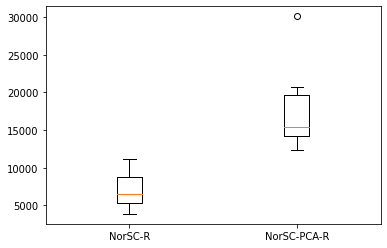

In [101]:
plt.boxplot(MAE_R)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model_R)
plt.show()

In [102]:
MAE_R

array([[ 9110.32106808, 15810.08745072],
       [ 9728.71977401, 14166.07293856],
       [ 3857.63240374, 14889.92092659],
       [ 5013.47290729, 20721.9269375 ],
       [ 7904.96549947, 30118.71075973],
       [ 5976.33929983, 14214.27547327],
       [11174.53405969, 20655.21934795],
       [ 6970.63411613, 16569.25495428],
       [ 5662.439818  , 12367.77413315],
       [ 5118.09396707, 13551.50829854]])

In [103]:
B_Hiperpara_R

[{'reg__alpha': 0.001, 'reg__solver': 'lsqr'},
 {'reg__alpha': 0.1, 'reg__solver': 'sag', 'rep__n_components': 0.9},
 {'reg__alpha': 0.001, 'reg__solver': 'lsqr'},
 {'reg__alpha': 1, 'reg__solver': 'sag', 'rep__n_components': 0.9},
 {'reg__alpha': 0.001, 'reg__solver': 'cholesky'},
 {'reg__alpha': 0.1, 'reg__solver': 'saga', 'rep__n_components': 0.9},
 {'reg__alpha': 0.01, 'reg__solver': 'lsqr'},
 {'reg__alpha': 0.01, 'reg__solver': 'saga', 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__solver': 'lsqr'},
 {'reg__alpha': 0.1, 'reg__solver': 'saga', 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__solver': 'lsqr'},
 {'reg__alpha': 0.001, 'reg__solver': 'saga', 'rep__n_components': 0.9},
 {'reg__alpha': 0.01, 'reg__solver': 'cholesky'},
 {'reg__alpha': 0.01, 'reg__solver': 'sag', 'rep__n_components': 0.9},
 {'reg__alpha': 0.01, 'reg__solver': 'lsqr'},
 {'reg__alpha': 0.01, 'reg__solver': 'sag', 'rep__n_components': 0.9},
 {'reg__alpha': 0.01, 'reg__solver': 'lsqr'},
 {'reg

In [104]:
steps =  [('scaler', StandardScaler()),
          #('rep', PCA(n_components=0.5)),                         
          ('reg', Ridge(alpha=0.001, solver='lsqr'))]

Mod_SC_R = Pipeline(steps = steps)
Mod_SC_R.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 Ridge(alpha=0.001, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='lsqr', tol=0.001))],
         verbose=False)

In [105]:
Xn = X[-1]
#Xn = [4881, 5142, 5379, 5948, 6207]
#Xn=np.matrix([Xn])

Xn = Xn.reshape(1,-1)
Pre_SC_R = Mod_SC_R.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo LinearRidge:',Pre_SC_R)

Número de contagiados en los últimos 5 días: [[4561 4881 5142 5379 5597]]
Predicción contagios para 2020-04-30 usando un modelo LinearRidge: [[6175.62330528]]


#### Validación Cruzada Anidada Lasso:

- Normalización StandadScalar
- Representación PCA
- Regresor LinearLasso

In [106]:
steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg',  Lasso())],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  Lasso())]
          ]

parameters = [
                {'reg__alpha':[1e-3,1e-2,1e-1,1],
                 },
                {'rep__n_components':[0.5,0.75,0.9],
                 'reg__alpha':[1e-3,1e-2,1e-1,1],
                 }
               ]

label_model_L = ['NorSC-L','NorSC-PCA-L']

B_Model_L, B_Hiperpara_L, MAE_L = V_Cruzada_Anidada(X,y,steps,parameters)

it 1/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0101s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175937.94235787392, tolerance: 21179.479424615387
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0121s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed

it 2/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0685s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  35 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  51 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


it 3/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188229.0705654481, tolerance: 17936.93677846154
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0067s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0067s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0488s.) Setting

it 4/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0352s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0092s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s


it 5/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43169.72040058975, tolerance: 22585.774384615383
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0071s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0071s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0960s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.3s remaining:    0.0s
[Pa

it 6/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0823s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0388s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0105s.) Setting batch_size=2.


it 7/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155774.9273009253, tolerance: 16271.250439999998
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0114s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0549s.) Setting batch_size=4.
[Para

it 8/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0446s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0878s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  51 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0139s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s


it 9/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145283.53722738905, tolerance: 22364.374753846158
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0071s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0071s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0529s.) Setting batch_size=8.
[P

it 10/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0677s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0675s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished


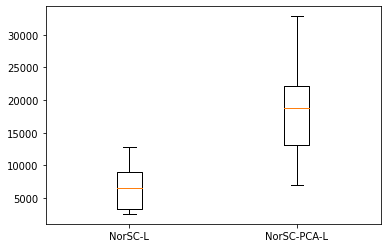

In [107]:
plt.boxplot(MAE_L)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model_L)
plt.show()

In [108]:
MAE_L

array([[ 3753.97694842, 16964.29016177],
       [ 7971.25134634, 22309.48176051],
       [ 3189.07408853, 12434.48859456],
       [12416.07916434, 32844.78890461],
       [ 5875.30798957, 15247.11595416],
       [ 2609.5560063 , 21463.09679673],
       [ 9314.12883125,  9685.96175543],
       [12821.77821251, 29879.65495537],
       [ 7165.37739318, 20626.10879779],
       [ 2551.44793299,  7012.66838528]])

In [109]:
B_Hiperpara_L

[{'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 1},
 {'reg__alpha': 1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5}]

In [110]:
steps =  [('scaler', StandardScaler()),
          #('rep', PCA(n_components=0.5)),                         
          ('reg', Ridge(alpha=0.1))]

Mod_SC_L = Pipeline(steps = steps)
Mod_SC_L.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 Ridge(alpha=0.1, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [111]:
Xn = X[-1]
#Xn = [4881, 5142, 5379, 5948, 6207]
#Xn=np.matrix([Xn])

Xn = Xn.reshape(1,-1)
Pre_SC_L = Mod_SC_L.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo LinearLasso:',Pre_SC_L)

Número de contagiados en los últimos 5 días: [[4561 4881 5142 5379 5597]]
Predicción contagios para 2020-04-30 usando un modelo LinearLasso: [[6230.63196885]]


#### Validación Cruzada Anidada EN:

- Normalización StandadScalar
- Representación PCA
- Regresor LinearElasticNet

In [112]:
steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg',  ElasticNet())],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  ElasticNet( ))]
          ]

parameters = [
                {'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
                 'reg__l1_ratio':[1e-3,1e-2,5e-1,75e-1,1e-1,1,10,100]
                 },
                {'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
                 'reg__l1_ratio':[1e-3,1e-2,5e-1,75e-1,1e-1,1,10,100],
                  'rep__n_components':[0.5,0.75,0.9]
                 }
               ]

label_model_EN = ['NorSC-EN','NorSC-PCA-EN']

B_Model_EN, B_Hiperpara_EN, MAE_EN = V_Cruzada_Anidada(X,y,steps,parameters)

it 1/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0186s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0455s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0788s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1062s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1435s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 206 out of 240 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finish

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0398s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0677s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1511s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 650 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0098s.)

it 2/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0749s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0713s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0860s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1267s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 233159.23760247888, tolerance: 15842.191153846154
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0473s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0982s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1296s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 665 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0140s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks  

it 3/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0938s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1224s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257736.85947397977, tolerance: 20873.174640000005
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0146s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0146s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1156s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1201s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  94 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 166 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 318 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 494 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 627 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 685 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 700 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 711 out of 720 | elapsed:    2.4s 

it 4/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1076s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1499s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 206 out of 240 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182417.86544566075, tolerance: 21047.857024615383
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0271s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0606s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0656s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1495s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1242s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 539 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 583 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 627 tasks   

it 5/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0094s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0687s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0365s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1352s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140669.64448372816, tolerance: 18

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0735s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  27 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1463s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 202 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 378 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 554 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 612 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 655 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 685 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 700 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 711 out of 720 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.4s finished
[Parallel(n_jo

it 6/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0097s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0442s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1086s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0863s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0797s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 206 out of 240 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0640s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 482 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 643 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 701 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0142s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0346s.) Setting batch_size=4.


it 7/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0966s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0921s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175102.85854708604, tolerance: 18989.023184615387
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0154s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks   

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1011s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1843s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 508 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 552 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 596 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 673 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 705 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0100s.) Setting batch_size=

it 8/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1860s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1493s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176425.44423010724, tolerance: 19287.288661538463
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0105s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computatio

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1027s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 650 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0096s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0434s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


it 9/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1042s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1368s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1092s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198211.27461356495, tolerance: 19370.54008615385
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0148s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0634s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1376s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 665 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0088s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0088s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks  

it 10/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1451s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  90 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0687s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 149 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 188 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 229 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163685.78119513032, tolerance: 17553.364439999998
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0117s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0817s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1055s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 650 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.4s finished


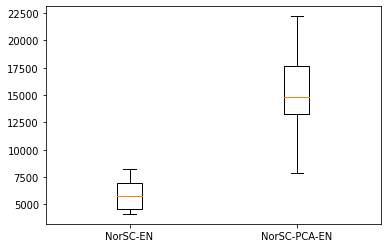

In [113]:
plt.boxplot(MAE_EN)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model_EN)
plt.show()

In [114]:
MAE_EN

array([[ 6066.81559387, 22216.03950601],
       [ 5525.55094647, 12975.42370695],
       [ 4248.8291056 , 17463.1114159 ],
       [ 6096.43528628,  7846.30730547],
       [ 8022.15507162, 20772.9025105 ],
       [ 4466.25632993, 14319.99755534],
       [ 5034.13319929, 14584.47662992],
       [ 4131.38679602, 12789.72554537],
       [ 7222.06638784, 17679.78019082],
       [ 8263.18957373, 15090.76601077]])

In [115]:
B_Hiperpara_EN

[{'reg__alpha': 0.01, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 10, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 0.5},
 {'reg__alpha': 0.01, 'reg__l1_ratio': 7.5, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.01, 'reg__l1_ratio': 7.5, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 7.5, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 7.5, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1, 'reg__l1_ratio': 1},
 {'reg__alpha': 10, 'reg__l1_ratio': 1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio':

In [116]:
steps =  [('scaler', StandardScaler()),
          #('rep', PCA(n_components=0.5)),                         
          ('reg', ElasticNet(alpha=0.001, l1_ratio=1))]

Mod_SC_EN = Pipeline(steps = steps)
Mod_SC_EN.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209201.25238111094, tolerance: 21897.137313846153
  positive)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=1, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

In [117]:
Xn = X[-1]
#Xn = [4881, 5142, 5379, 5948, 6207]
#Xn=np.matrix([Xn])

Xn = Xn.reshape(1,-1)
Pre_SC_EN = Mod_SC_EN.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo LinearElasticNet:',Pre_SC_EN)

Número de contagiados en los últimos 5 días: [[4561 4881 5142 5379 5597]]
Predicción contagios para 2020-04-30 usando un modelo LinearElasticNet: [6256.08574286]


#### Validación Cruzada Anidada KR:

- Normalización StandadScalar
- Representación PCA
- Regresor KernelRidge

In [118]:
steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg',  KernelRidge(kernel = 'rbf'))],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  KernelRidge(kernel = 'rbf'))]
          ]

parameters = [
                {'reg__gamma':[1e-3,1e-2,1e-1,1,10,100],
                 'reg__alpha':[1e-3,1e-2,1e-1,1,10,100]
                 },
                {'reg__gamma':[1e-3,1e-2,1e-1,1,10,100],
                 'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
                 'rep__n_components':[0.5,0.75,0.9]
                 }
               ]

label_model_KR = ['NorSC-KRRBF','NorSC-PCA-KRRBF']

B_Model_KR, B_Hiperpara_KR, MAE_KR = V_Cruzada_Anidada(X,y,steps,parameters)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0234s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0587s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0436s.) Setting batch_size=8.


it 1/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1709s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 143 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0162s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0708s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0628s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1602s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0078s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0

it 2/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0619s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0693s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0879s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  94 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 138 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 163 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0173s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computatio

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1052s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1486s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0123s.) Setting batch_size=2

it 3/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0846s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1697s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 143 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0081s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0081s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0524s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  24 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 186 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 274 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 362 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 466 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 531 out of 540 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0143s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s


it 4/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0448s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0854s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1451s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  86 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 130 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0174s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computatio

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0857s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1201s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1587s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 384 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 459 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 472 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 518 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0079s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks 

it 5/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1247s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0197s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0197s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0570s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0903s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  90 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 194 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 338 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 469 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0167s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0372s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks  

it 6/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0623s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1306s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0193s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0563s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0738s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1510s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers

it 7/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0613s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1176s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 125 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 141 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 163 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0175s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0492s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0811s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.0s
[Paralle

it 8/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1423s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 125 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 141 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 163 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0084s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0084s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0717s.) Setting batch_size=8.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0805s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  82 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 178 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 483 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0070s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0070s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0444s.) Setting batch_size=8.


it 9/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0634s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1146s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 107 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 170 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0204s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0204s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0452s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0876s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 210 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 354 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend Lo

it 10/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0680s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0944s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  90 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 120 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 143 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 165 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0161s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0161s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks  

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0439s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1375s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 214 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 378 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 449 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 460 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 515 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished


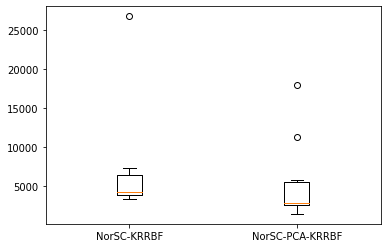

In [119]:
plt.boxplot(MAE_KR)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model_KR)
plt.show()

In [120]:
val = 100*100
cont = -1
for i in range(MAE_KR.shape[0]):
  for j in range(MAE_KR.shape[1]):
    cont +=1    
    if (val > MAE_KR[i,j]):
      val = MAE_KR[i,j]
      pos = cont

print(pos)
print(val)

11
1401.116992332871


In [121]:
MAE_KR

array([[26748.79044355, 17896.91058806],
       [ 7280.61065663,  4452.67266784],
       [ 4203.7230048 ,  2679.14637029],
       [ 3329.21948239,  2230.60647068],
       [ 3804.75537849,  5763.56944241],
       [ 3941.17015154,  1401.11699233],
       [ 4340.30653241,  2505.79817368],
       [ 4681.35376752,  2616.39430818],
       [ 3452.79333672,  2946.85770705],
       [ 6963.04803807, 11236.54809235]])

In [122]:
B_Model_KR[pos]

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)

In [123]:
print(B_Hiperpara_KR[pos])
B_Hiperpara_KR

{'reg__alpha': 0.001, 'reg__gamma': 1, 'rep__n_components': 0.5}


[{'reg__alpha': 0.001, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.01},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.01},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.01},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.01},
 {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.01},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.01},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.01},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_compo

In [124]:
steps =  [('scaler', StandardScaler()),
          ('rep', PCA(n_components=0.5)),                         
          ('reg', KernelRidge(alpha=0.001, kernel='rbf', gamma=0.01))]

Mod_SC_PCA_KRrbf = Pipeline(steps = steps)
Mod_SC_PCA_KRrbf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.01,
                             kernel='rbf', kernel_params=None))],
         verbose=False)

In [125]:
Xn = X[-1]
#Xn = [4881, 5142, 5379, 5948, 6207]
#Xn=np.matrix([Xn])

Xn = Xn.reshape(1,-1)
Pre_SC_PCA_KRrbf = Mod_SC_PCA_KRrbf.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo KernelRidge_rbf:',Pre_SC_PCA_KRrbf)

Número de contagiados en los últimos 5 días: [[4561 4881 5142 5379 5597]]
Predicción contagios para 2020-04-30 usando un modelo KernelRidge_rbf: [[6245.88155132]]


In [126]:
print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo LinearRegression:',Pre_SC_LR)
print('Predicción contagios para',date.today(),'usando un modelo LinearRidge:',Pre_SC_R)
print('Predicción contagios para',date.today(),'usando un modelo LinearLasso:',Pre_SC_L)
print('Predicción contagios para',date.today(),'usando un modelo LinearElasticNet:',Pre_SC_EN)
print('Predicción contagios para',date.today(),'usando un modelo KernelRidge_rbf:',Pre_SC_PCA_KRrbf)

Número de contagiados en los últimos 5 días: [[4561 4881 5142 5379 5597]]
Predicción contagios para 2020-04-30 usando un modelo LinearRegression: [[6176.07241785]]
Predicción contagios para 2020-04-30 usando un modelo LinearRidge: [[6175.62330528]]
Predicción contagios para 2020-04-30 usando un modelo LinearLasso: [[6230.63196885]]
Predicción contagios para 2020-04-30 usando un modelo LinearElasticNet: [6256.08574286]
Predicción contagios para 2020-04-30 usando un modelo KernelRidge_rbf: [[6245.88155132]]
